In [1]:
import numpy as np

from matplotlib import pyplot as plt

from scipy.optimize import root_scalar

from shapely import LineString, Point

from pycivil.sections.concreteSections import RectConcreteSct
import pycivil.sections.rebarSections as Rsct
import pycivil.sections.section as Sct
import pycivil.ACI318_19.sectional_strength.PMManalysis as PMManalysis
import pycivil.ACI318_19.sectional_strength.Manalysis as Manalysis
import pycivil.ACI318_19.designProps as props
import pycivil.ACI318_19.assumptions as assump

In [2]:
d20 = Rsct.d20
d12 = Rsct.d12

sct = RectConcreteSct(b=500, h=700)
# sct.rebarCoords = Rsct.RectRebarsSct(sct.section, 5, 4, d20, 50)
# sct = CircConcreteSct(d=600)
# sct.rebarCoords = Rsct.CircRebarsSct(600, 7, d20, 70)

data = props.setDesignDataFromSection(sct)

In [34]:
minx, miny, maxx, maxy = data.section.bounds
d = maxy - miny - data.clear_cover - data.max_conf_rebar_size - (data.max_rebar_size/2)
coords = np.array([Point((maxx-minx)/2, d)])
data.As
# Manalysis.calc_es(data.section, coords, d)

array([], dtype=float32)

In [32]:
minx, miny, maxx, maxy = data.section.bounds
d = maxy - miny - data.clear_cover - data.max_conf_rebar_size - (data.max_rebar_size/2)
coords = np.array([Point((maxx-minx)/2, d)])
new_data = Manalysis.set_As(data, np.array([15000], dtype=np.float32))
c = Manalysis.calc_c(new_data)
print(c)
abs(np.min(Manalysis.calc_es(new_data.section, coords, c)))

664.3598429569039


0.004264375035464763

In [ ]:
minx, miny, maxx, maxy = data.section.bounds
d = maxy - miny - data.clear_cover - data.max_conf_rebar_size - (data.max_rebar_size/2)
coords = np.array([Point((maxx-minx)/2, d)])

def _optim_As(x):
    new_data = Manalysis.set_As(data, np.array([x], dtype=np.float32))
    c = Manalysis.calc_c(new_data)
    min_es = np.min(Manalysis.calc_es(new_data.section, coords, c))
    return abs(min_es) - 0.005

root_scalar(_optim_As, bracket=[1, 0.08*500*700])

In [14]:
min_rebar = 2*d12
max_rebar = 20*d20

minx, miny, maxx, maxy = data.section.bounds
d = maxy - miny - data.clear_cover - data.max_conf_rebar_size - (data.max_rebar_size/2)

data.coords = np.array([Point((maxx-minx)/2, d)])
As_list = np.linspace(min_rebar.area, max_rebar.area, num=30)
data_list = np.array([Manalysis.set_As(data, np.array([As])) for As in As_list])
M_list = np.array([Manalysis.calc_M(_data, Manalysis.calc_c(_data))[0] for _data in data_list] )
min_es = [np.min(Manalysis.calc_es(_data.section, _data.coords, Manalysis.calc_c(_data))) for _data in data_list]

print(min_es)

[-0.2904687181657004, -0.14957872355311427, -0.10008779610770019, -0.07483951853379096, -0.05952571226107932, -0.04924688811155588, -0.041870471726871646, -0.03631923155943885, -0.03199033257158031, -0.02852008966874133, -0.02567607690708755, -0.02330281169979416, -0.02129234888125352, -0.019567403072913655, -0.018071184968757387, -0.016761029352763798, -0.015604261129417197, -0.014575433021914592, -0.013654431783837809, -0.012825150200329661, -0.012074537024418514, -0.011391905048173752, -0.010768419028283483, -0.010196711189226, -0.00967058870046052, -0.009184808444163944, -0.008734901681258012, -0.0083170361780071, -0.00792790677677413, -0.007564647792267956]


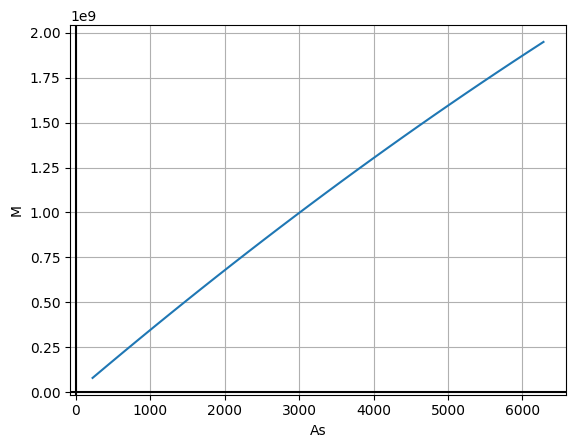

In [13]:
fig, axs = plt.subplots()
axs.plot(As_list, M_list)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.set_xlabel("As")
axs.set_ylabel("M")
axs.grid(True)
plt.show()

In [13]:
minx, miny, maxx, maxy = data.section.bounds
d = maxy - miny - data.clear_cover - data.max_conf_rebar_size - (data.max_rebar_size/2)
print(d)
coords = np.array([Point((maxx-minx)/2, d)])
data.coords = coords
As_list = np.array([])
c_list = np.array([])
As = 100
value = 100
while True:
    _data = Manalysis.set_As(data, np.array([As]))
    _c = Manalysis.calc_c(_data)
    if _c >= d: break
    As_list = np.append(As_list, As)
    c_list = np.append(c_list, _c)
    As += value

630.0


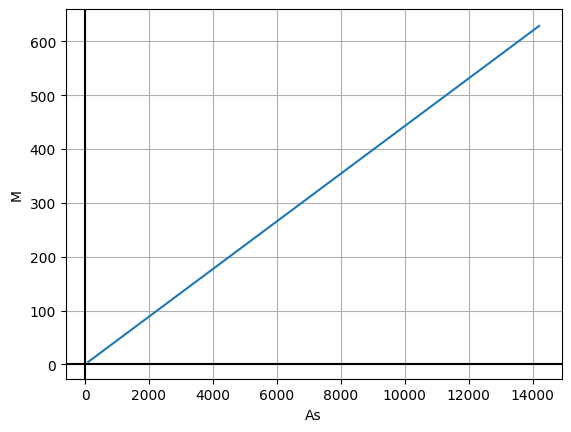

In [14]:
fig, axs = plt.subplots()
axs.plot(As_list, c_list)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.set_xlabel("As")
axs.set_ylabel("M")
axs.grid(True)
plt.show()